VERSIONE 1 (una sola classe spettrale)

Generazione degli spettri "sintetici"

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Dizionario di linee (nell'ottico e fino al Fe) - senza intensity (ma compatibile se aggiungi intensity)
spectral_lines = {
    "H": {"lines": [656.28, 486.13, 434.05, 410.17], "names": ["Hα", "Hβ", "Hγ", "Hδ"]},
    "He": {"lines": [587.56, 447.15, 388.87], "names": ["He I 587.56", "He I 447.15", "He I 388.87"]},
    "Li": {"lines": [670.776, 610.36], "names": ["Li I 670.776", "Li I 610.36"]},
    "C": {"lines": [426.7003, 392.0693, 514.516], "names": ["C I 426.7003", "C I 392.0693", "C I 514.516"]},
    "N": {"lines": [500.509, 444.677, 692.70], "names": ["N II 500.509", "N II 444.677", "N I 692.70"]},
    "O": {"lines": [615.598, 615.677, 615.818], "names": ["O I 615.598", "O I 615.677", "O I 615.818"]},
    "Na": {"lines": [589.0, 589.6], "names": ["Na D1", "Na D2"]},
    "Mg": {"lines": [516.73, 517.27, 518.36], "names": ["Mg b1 516.73", "Mg b2 517.27", "Mg b3 518.36"]},
    "Al": {"lines": [394.4, 396.15], "names": ["Al I 394.4", "Al I 396.15"]},
    "Si": {"lines": [390.55, 566.67, 615.51], "names": ["Si I 390.55", "Si I 566.67", "Si I 615.51"]},
    "P": {"lines": [533.60, 604.32], "names": ["P I 533.60", "P I 604.32"]},
    "S": {"lines": [469.57, 605.25, 675.70], "names": ["S I 469.57", "S I 605.25", "S I 675.70"]},
    "Ca": {"lines": [393.4, 396.8], "names": ["Ca II K 393.4", "Ca II H 396.8"]},
    "Sc": {"lines": [424.68, 431.79, 432.00], "names": ["Sc II 424.68", "Sc II 431.79", "Sc I 432.00"]},
    "Ti": {"lines": [365.0, 399.8, 429.0, 491.5], "names": ["Ti I 365.0", "Ti I 399.8", "Ti I 429.0", "Ti I 491.5"]},
    "V": {"lines": [411.18, 437.92, 437.99], "names": ["V I 411.18", "V I 437.92", "V I 437.99"]},
    "Cr": {"lines": [425.43, 428.97, 520.56], "names": ["Cr I 425.43", "Cr I 428.97", "Cr I 520.56"]},
    "Mn": {"lines": [403.08, 403.30, 403.45], "names": ["Mn I 403.08", "Mn I 403.30", "Mn I 403.45"]},
    "Fe": {"lines": [404.58, 438.35, 495.76, 527.03, 532.84], "names": ["Fe I 404.58", "Fe I 438.35", "Fe I 495.76", "Fe I 527.03", "Fe I 532.84"]}
}

# Parametri immagine
num_images_per_element = 100
wl_min, wl_max = 380, 750  # nm
pixels = 2048  # punti asse X
noise_level = 0.02  # rumore assoluto (dato che continuum è ~1)
shift_mean = 0.1  
shift_sigma = 1
img_width_px = 512
img_height_px = 128
dpi = 100

output_folder = "prova"
os.makedirs(output_folder, exist_ok=True)

def generate_absorption_spectrum(element_info, wl_min=380, wl_max=750, pixels=512,
                                 noise_level=0.02, shift_mean=0.1, shift_sigma=1
                                ):
    wl_axis = np.linspace(wl_min, wl_max, pixels)
    continuum = 1.0
    flux = np.ones_like(wl_axis) * continuum  # continuum normalizzato a 1

    lines = np.array(element_info["lines"], dtype=float)

    # determina depths:
    depths = np.random.uniform(0.3, 0.8, size=len(lines))

    # simulo shift laterale
    shift = np.random.normal(loc=shift_mean, scale=shift_sigma)
    shifted_lines = lines + shift

    # costruisci profili di assorbimento (sottrazione dal continuum)
    for lam0, depth in zip(shifted_lines, depths):
        sigma = max(0.1, np.random.normal(loc=0.1, scale=5))   # nm, varia larghezza righe (strumentale/thermal/rot)
        profile = depth * np.exp(-0.5 * ((wl_axis - lam0) / sigma)**2)
        flux -= profile  # sottrai: crea la valle

    # aggiungi piccolo offset di background (es. flusso di base leggermente >0)
    background = np.random.uniform(0.0, 0.02)
    flux += background

    # aggiungi rumore gaussiano (assoluto, visto continuum ~1)
    flux += np.random.normal(0, noise_level, size=flux.shape)

    # evita valori negativi
    flux = np.clip(flux, 0.0, None)

    return wl_axis, flux

# impostazioni salvataggio
figsize = (img_width_px / dpi, img_height_px / dpi)
normalize_each_image = False  # per absorption tipicamente si lavora con continuum=1, quindi False è ok

for element, info in spectral_lines.items():
    element_folder = os.path.join(output_folder, element)
    os.makedirs(element_folder, exist_ok=True)

    for i in range(num_images_per_element):
        wl, flux = generate_absorption_spectrum(info, wl_min, wl_max, pixels,
                                                noise_level, shift_mean,
                                                shift_sigma)
        # eventualmente scala esposizione
        flux *= np.random.uniform(0.95, 1.05)

        # opzionale normalizzazione (solitamente non necessaria)
        if normalize_each_image:
            if flux.max() > 0:
                flux = flux / flux.max()

        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = fig.add_subplot(111)
        ax.plot(wl, flux, linewidth=1.2, color='black')
        ax.set_xlim(wl_min, wl_max)
        ax.set_ylim(0, 1.05)  # continuum ~1
        ax.axis("off")
        filename = os.path.join(element_folder, f"{element}_{i:04d}.png")
        fig.savefig(filename, dpi=dpi)
        plt.close(fig)


Creazione del modello

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Verifica versione
print("TensorFlow:", tf.__version__)


TensorFlow: 2.11.0


In [2]:
# carico i dati per il training

img_size = (128, 128)   # puoi modificare la risoluzione
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "training_specta_1",
    validation_split=0.2,   # 80% training, 20% validation
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "training_specta_1",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classi trovate:", class_names)


Found 19000 files belonging to 19 classes.
Using 15200 files for training.
Found 19000 files belonging to 19 classes.
Using 3800 files for validation.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']


2025-08-26 10:33:47.397544: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


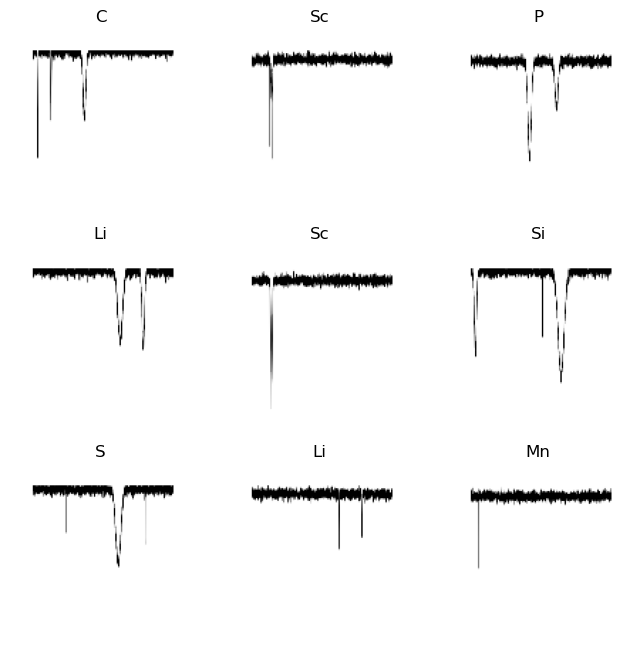

In [6]:
import matplotlib.pyplot as plt

# mostra immagine che verrà usata per il training

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):   # prende il primo batch
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.show()


In [7]:
# costruisco la rete

num_classes = len(class_names)

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=img_size + (3,)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [9]:
# addestramento

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

AUTOTUNE = tf.data.AUTOTUNE

# ottimizza la pipeline (adatta cache se i dati stanno in RAM)
train_ds = train_ds.shuffle(1000)
# train_ds = train_ds.cache()         # decommenta se i dati entrano in memoria
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# callbacks utili
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='logs')
]

# quanti epochs provare (lascia EarlyStopping fare il resto)
EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
475/475 [==============================] - 88s 179ms/step - loss: 0.6040 - accuracy: 0.8010 - val_loss: 0.0800 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 2/50
475/475 [==============================] - 93s 190ms/step - loss: 0.1165 - accuracy: 0.9449 - val_loss: 0.0697 - val_accuracy: 0.9632 - lr: 0.0010
Epoch 3/50
475/475 [==============================] - 97s 198ms/step - loss: 0.0943 - accuracy: 0.9513 - val_loss: 0.0693 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 4/50
475/475 [==============================] - 99s 201ms/step - loss: 0.0896 - accuracy: 0.9536 - val_loss: 0.0651 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 5/50
475/475 [==============================] - 98s 200ms/step - loss: 0.0772 - accuracy: 0.9570 - val_loss: 0.0713 - val_accuracy: 0.9674 - lr: 0.0010
Epoch 6/50
475/475 [==============================] - 98s 200ms/step - loss: 0.0842 - accuracy: 0.9577 - val_loss: 0.0633 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 7/50
475/475 [==============================] 

Interpretazione pratica (trend)

- train_loss scende e val_loss scende → tutto ok, modello sta imparando e generalizza.

- train_loss scende e val_loss sale → overfitting: il modello impara i dettagli del training ma peggiora sui dati nuovi.

- train_loss elevato e val_loss elevato → underfitting: modello troppo semplice o training insufficiente.

- val_loss molto rumorosa → forse batch di validazione piccoli, metriche poco stabili o dati eterogenei.

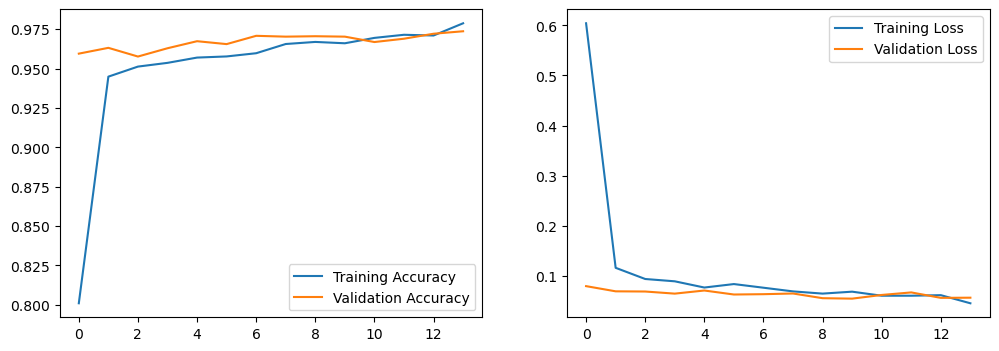

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()

plt.show()


In [8]:
# predizione modello

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

img_size = (128, 128)
img_path = "new_spectra/Si/Si_0002.png"  # esempio
img = load_img(img_path, target_size=img_size)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Classe predetta:", class_names[np.argmax(score)])
print("Confidenza:", 100 * np.max(score))

probs = score.numpy().flatten()

for i, p in enumerate(probs):
    print(f"{class_names[i]}: {p:.4f}")


1/1 [==============================] - 0s 19ms/step
Classe predetta: Si
Confidenza: 13.12020868062973
Al: 0.0483
C: 0.0483
Ca: 0.0483
Cr: 0.0483
Fe: 0.0483
H: 0.0483
He: 0.0483
Li: 0.0483
Mg: 0.0483
Mn: 0.0483
N: 0.0483
Na: 0.0483
O: 0.0483
P: 0.0483
S: 0.0483
Sc: 0.0483
Si: 0.1312
Ti: 0.0483
V: 0.0483


In [13]:
# salvo il modello

model.save("mymodel_spectra") 


INFO:tensorflow:Assets written to: mymodel_spectra/assets


INFO:tensorflow:Assets written to: mymodel_spectra/assets


In [15]:
# verifico accuratezza con spettri "nuovi"

img_size = (128, 128)  # usa la stessa dimensione del training
batch_size = 32

# Carica il dataset dalle cartelle
newdata = keras.utils.image_dataset_from_directory(
    "new_spectra",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # molto importante per tenere l'ordine
)

# Le classi (nomi delle cartelle)
class_names = newdata.class_names
print("Classi trovate:", class_names)

# Predizioni su tutto il dataset
predictions = model.predict(newdata)
predicted_labels = tf.argmax(predictions, axis=1, output_type=tf.int32)
true_labels = tf.concat([y for x, y in newdata], axis=0)

# Calcola accuratezza
accuracy = tf.reduce_mean(tf.cast(predicted_labels == true_labels, tf.float32)).numpy()
print(f"Accuratezza sul dataset: {accuracy:.2%}")


Found 1900 files belonging to 19 classes.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']
60/60 [==============================] - 3s 48ms/step
Accuratezza sul dataset: 97.47%


In [1]:
from tensorflow import keras

model = keras.models.load_model("mymodel_spectra")


VERSIONE 2 (più classi spettrali nella stessa immagine)

In [6]:
# genero spettri "compositi"

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd

# Dizionario di linee (nell'ottico e fino al Fe) - senza intensity (ma compatibile se aggiungi intensity)
spectral_lines = {
    "H": {"lines": [656.28, 486.13, 434.05, 410.17], "names": ["Hα", "Hβ", "Hγ", "Hδ"]},
    "He": {"lines": [587.56, 447.15, 388.87], "names": ["He I 587.56", "He I 447.15", "He I 388.87"]},
    "Li": {"lines": [670.776, 610.36], "names": ["Li I 670.776", "Li I 610.36"]},
    "C": {"lines": [426.7003, 392.0693, 514.516], "names": ["C I 426.7003", "C I 392.0693", "C I 514.516"]},
    "N": {"lines": [500.509, 444.677, 692.70], "names": ["N II 500.509", "N II 444.677", "N I 692.70"]},
    "O": {"lines": [615.598, 615.677, 615.818], "names": ["O I 615.598", "O I 615.677", "O I 615.818"]},
    "Na": {"lines": [589.0, 589.6], "names": ["Na D1", "Na D2"]},
    "Mg": {"lines": [516.73, 517.27, 518.36], "names": ["Mg b1 516.73", "Mg b2 517.27", "Mg b3 518.36"]},
    "Al": {"lines": [394.4, 396.15], "names": ["Al I 394.4", "Al I 396.15"]},
    "Si": {"lines": [390.55, 566.67, 615.51], "names": ["Si I 390.55", "Si I 566.67", "Si I 615.51"]},
    "P": {"lines": [533.60, 604.32], "names": ["P I 533.60", "P I 604.32"]},
    "S": {"lines": [469.57, 605.25, 675.70], "names": ["S I 469.57", "S I 605.25", "S I 675.70"]},
    "Ca": {"lines": [393.4, 396.8], "names": ["Ca II K 393.4", "Ca II H 396.8"]},
    "Sc": {"lines": [424.68, 431.79, 432.00], "names": ["Sc II 424.68", "Sc II 431.79", "Sc I 432.00"]},
    "Ti": {"lines": [365.0, 399.8, 429.0, 491.5], "names": ["Ti I 365.0", "Ti I 399.8", "Ti I 429.0", "Ti I 491.5"]},
    "V": {"lines": [411.18, 437.92, 437.99], "names": ["V I 411.18", "V I 437.92", "V I 437.99"]},
    "Cr": {"lines": [425.43, 428.97, 520.56], "names": ["Cr I 425.43", "Cr I 428.97", "Cr I 520.56"]},
    "Mn": {"lines": [403.08, 403.30, 403.45], "names": ["Mn I 403.08", "Mn I 403.30", "Mn I 403.45"]},
    "Fe": {"lines": [404.58, 438.35, 495.76, 527.03, 532.84], "names": ["Fe I 404.58", "Fe I 438.35", "Fe I 495.76", "Fe I 527.03", "Fe I 532.84"]}
}


wl_min, wl_max = 380, 750
pixels = 2048   
img_width_px = 512
img_height_px = 128
dpi = 100
noise_level = 0.02  # rumore assoluto (dato che continuum è ~1)
shift_mean = 0.1  
shift_sigma = 1

def make_line_profile(element_info, wl_axis, depth_scale=1.0, shift_mean=0.1, shift_sigma=1.0):
    """Ritorna l'array del profilo di assorbimento (solo la somma delle 'valli') per quell'elemento."""
    lines = np.array(element_info["lines"], dtype=float)
    # profondità base per ogni linea
    depths = np.random.uniform(0.3, 0.8, size=len(lines)) * depth_scale
    # shift globale per quell'elemento
    shift = np.random.normal(loc=shift_mean, scale=shift_sigma)
    shifted_lines = lines + shift

    profile_sum = np.zeros_like(wl_axis)
    for lam0, depth in zip(shifted_lines, depths):
        sigma = max(0.1, np.random.normal(loc=0.1, scale=5))  # larghezza riga (nm)
        profile = depth * np.exp(-0.5 * ((wl_axis - lam0) / sigma) ** 2)
        profile_sum += profile

    return profile_sum

def generate_composite_spectrum(
    available_elements,
    wl_min=380, wl_max=750, pixels=2048,
    min_components=2, max_components=4,
    noise_level=0.02,
    dominant_boost=(1.2, 2.0),
    other_boost=(0.4, 0.6),
    shift_mean=0.1, shift_sigma=1.0
):
    """
    Crea un singolo spettro composito e restituisce (wl_axis, flux, dominant_element_name, components_list)
    """
    wl_axis = np.linspace(wl_min, wl_max, pixels)
    continuum = 1.0

    # scegli quante specie mettere (2..4)
    k = random.randint(min_components, max_components)
    elems = random.sample(list(available_elements.keys()), k)

    # scegli dominante (tra quelli selezionati)
    dominant = random.choice(elems)

    total_profile = np.zeros_like(wl_axis)

    for el in elems:
        info = available_elements[el]
        if el == dominant:
            scale = np.random.uniform(*dominant_boost)
        else:
            scale = np.random.uniform(*other_boost)

        profile = make_line_profile(info, wl_axis, depth_scale=scale,
                                    shift_mean=shift_mean, shift_sigma=shift_sigma)
        total_profile += profile

    # costruisci flusso: continuum - profili + background + rumore
    background = np.random.uniform(0.0, 0.02)
    flux = continuum - total_profile
    flux += background
    flux += np.random.normal(0, noise_level, size=flux.shape)
    flux = np.clip(flux, 0.0, None)

    return wl_axis, flux, dominant, elems



figsize = (img_width_px / dpi, img_height_px / dpi)
normalize_each_image = False  # come prima

output_folder = "new_composite_spectra"
os.makedirs(output_folder, exist_ok=True)


num_images_per_dominant = 100  # quanti spettri dominanti per elemento (modifica come vuoi)
records = []

for element in spectral_lines.keys():
    element_folder = os.path.join(output_folder, element)
    os.makedirs(element_folder, exist_ok=True)

# Genera immagini mescolate ma salva nella cartella dell'elemento dominante
counter = {el: 0 for el in spectral_lines.keys()}

total_to_generate = num_images_per_dominant * len(spectral_lines)
i = 0
while any(counter[el] < num_images_per_dominant for el in spectral_lines.keys()):
    wl, flux, dominant, comps = generate_composite_spectrum(
        spectral_lines,
        wl_min=wl_min, wl_max=wl_max, pixels=pixels,
        noise_level=noise_level,
        shift_mean=shift_mean, shift_sigma=shift_sigma
    )

    # controlla se per il dominante abbiamo ancora slot liberi
    if counter[dominant] >= num_images_per_dominant:
        # salta e rigenera (per bilanciare uniformemente)
        continue

    # analogo al tuo script: exposure scaling
    flux *= np.random.uniform(0.95, 1.05)

    if normalize_each_image:
        if flux.max() > 0:
            flux = flux / flux.max()

    # salva figura EXACT same format
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_subplot(111)
    ax.plot(wl, flux, linewidth=1.2, color='black')
    ax.set_xlim(wl_min, wl_max)
    ax.set_ylim(0, 1.05)
    ax.axis("off")

    fname = f"{dominant}_{counter[dominant]:04d}.png"
    path = os.path.join(output_folder, dominant, fname)
    fig.savefig(path, dpi=dpi)
    plt.close(fig)

    records.append({"filename": path, "label": dominant, "components": ";".join(comps)})
    counter[dominant] += 1
    i += 1

# salva csv con etichette (utile per training successivo)
import pandas as pd
df = pd.DataFrame(records)
df.to_csv(os.path.join(output_folder, "labels.csv"), index=False)

print("Finito. Immagini salvate in:", output_folder)

Finito. Immagini salvate in: new_composite_spectra


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Verifica versione
print("TensorFlow:", tf.__version__)


TensorFlow: 2.11.0


In [2]:
# carico i dati per il training

img_size = (128, 128)   # puoi modificare la risoluzione
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "composite_by_dominant",
    validation_split=0.2,   # 80% training, 20% validation
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "composite_by_dominant",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classi trovate:", class_names)


Found 19000 files belonging to 19 classes.
Using 15200 files for training.
Found 19000 files belonging to 19 classes.
Using 3800 files for validation.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']


2025-08-27 16:17:16.725631: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


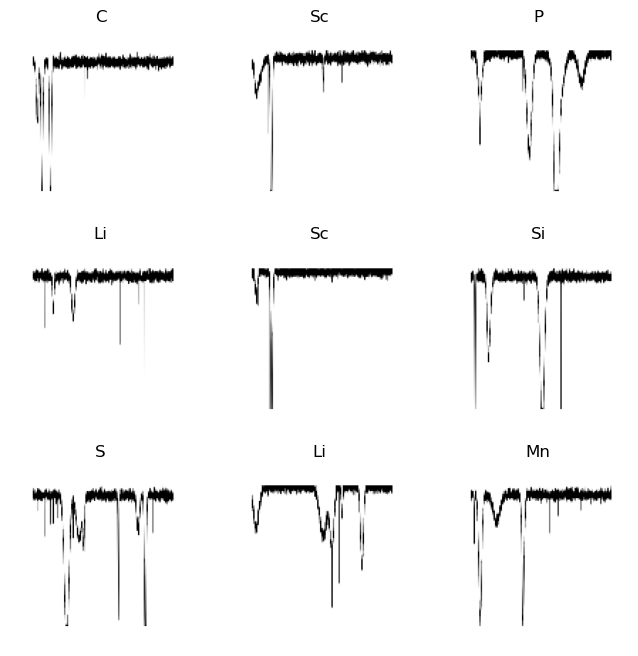

In [3]:
import matplotlib.pyplot as plt

# mostra immagine che verrà usata per il training

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):   # prende il primo batch
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')
plt.show()


In [12]:
# uso il vecchio modello come base di partenza (transfer learning)

from tensorflow import keras
from tensorflow.keras import layers, models

# 1) Carico il modello vecchio
old_model = keras.models.load_model("mymodel_spectra")

# 2) Congelo tutti i layer del vecchio modello
for layer in old_model.layers:
    layer.trainable = False

# 3) Prendo l’output penultimo (quello prima della classificazione vecchia)
base_output = old_model.layers[-2].output  

# 4) Aggiungo un hidden layer extra + nuovo classificatore
x = layers.Dense(128, activation="relu", name="transfer_hidden")(base_output)
x = layers.Dropout(0.3, name="transfer_dropout")(x)
new_output = layers.Dense(len(class_names), activation="softmax", name="transfer_output")(x)

# 5) Creo il nuovo modello
composite_model = models.Model(inputs=old_model.input, outputs=new_output)

# 6) Compilo
composite_model.compile(
    optimizer = keras.optimizers.SGD(
    learning_rate=1e-2,   # tipicamente più alto di Adam
    momentum=0.9,
    nesterov=True),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

composite_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0     

In [ ]:
# addestramento

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

AUTOTUNE = tf.data.AUTOTUNE

# ottimizza la pipeline (adatta cache se i dati stanno in RAM)
train_ds = train_ds.shuffle(1000)
# train_ds = train_ds.cache()         # decommenta se i dati entrano in memoria
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# callbacks utili
callbacks = [
    ModelCheckpoint('best_composite_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='logs')
]

# quanti epochs provare (lascia EarlyStopping fare il resto)
EPOCHS = 40

history = composite_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/40
475/475 [==============================] - 31s 60ms/step - loss: 1.6547 - accuracy: 0.5470 - val_loss: 0.9397 - val_accuracy: 0.7508 - lr: 0.0100
Epoch 2/40
475/475 [==============================] - 34s 66ms/step - loss: 1.3698 - accuracy: 0.6015 - val_loss: 0.9029 - val_accuracy: 0.7526 - lr: 0.0100
Epoch 3/40
475/475 [==============================] - 36s 70ms/step - loss: 1.2959 - accuracy: 0.6214 - val_loss: 0.8438 - val_accuracy: 0.7711 - lr: 0.0100
Epoch 4/40
475/475 [==============================] - 37s 72ms/step - loss: 1.2893 - accuracy: 0.6261 - val_loss: 0.9138 - val_accuracy: 0.7597 - lr: 0.0100
Epoch 5/40
475/475 [==============================] - 37s 73ms/step - loss: 1.2670 - accuracy: 0.6356 - val_loss: 0.8664 - val_accuracy: 0.7592 - lr: 0.0100
Epoch 6/40
475/475 [==============================] - ETA: 0s - loss: 1.2490 - accuracy: 0.6456
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
475/475 [==============================] - 3

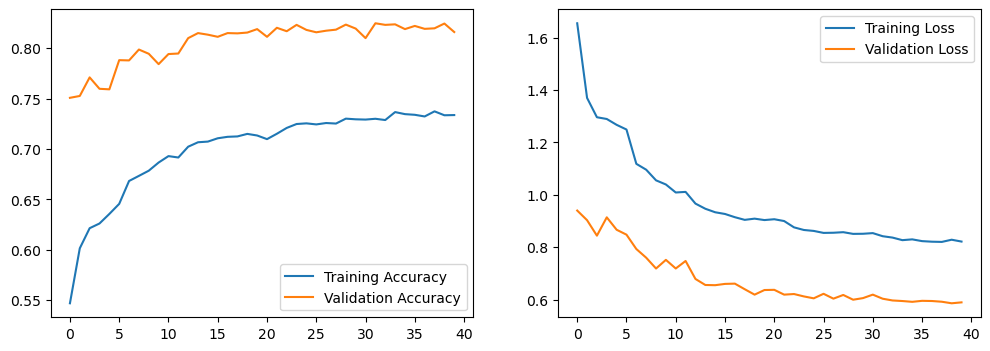

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()

plt.show()


In [14]:
# salvo il modello

composite_model.save("mymodel_composite_sgd_40epochs") 

INFO:tensorflow:Assets written to: mymodel_composite_sgd_40epochs/assets


INFO:tensorflow:Assets written to: mymodel_composite_sgd_40epochs/assets


In [2]:
from tensorflow import keras

model = keras.models.load_model("best_composite_model.h5")


In [26]:
# predizione modello

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

img_size = (128, 128)
img_path = "new_composite_spectra/He/He_0011.png"  # esempio
img = load_img(img_path, target_size=img_size)
img_array = img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Classe predetta:", class_names[np.argmax(score)])
print("Confidenza:", 100 * np.max(score))

probs = score.numpy().flatten()

for i, p in enumerate(probs):
    print(f"{class_names[i]}: {p:.4f}")


1/1 [==============================] - 0s 22ms/step
Classe predetta: He
Confidenza: 12.214531749486923
Al: 0.0490
C: 0.0486
Ca: 0.0491
Cr: 0.0486
Fe: 0.0486
H: 0.0486
He: 0.1221
Li: 0.0486
Mg: 0.0486
Mn: 0.0486
N: 0.0486
Na: 0.0512
O: 0.0486
P: 0.0486
S: 0.0486
Sc: 0.0486
Si: 0.0486
Ti: 0.0486
V: 0.0486


In [27]:
# verifico accuratezza con spettri "nuovi"

img_size = (128, 128)  # usa la stessa dimensione del training
batch_size = 32

# Carica il dataset dalle cartelle
newdata = keras.utils.image_dataset_from_directory(
    "new_composite_spectra",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # molto importante per tenere l'ordine
)

# Le classi (nomi delle cartelle)
class_names = newdata.class_names
print("Classi trovate:", class_names)

# Predizioni su tutto il dataset
predictions = model.predict(newdata)
predicted_labels = tf.argmax(predictions, axis=1, output_type=tf.int32)
true_labels = tf.concat([y for x, y in newdata], axis=0)

# Calcola accuratezza
accuracy = tf.reduce_mean(tf.cast(predicted_labels == true_labels, tf.float32)).numpy()
print(f"Accuratezza sul dataset: {accuracy:.2%}")


Found 1900 files belonging to 19 classes.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']
60/60 [==============================] - 3s 50ms/step
Accuratezza sul dataset: 81.47%


In [28]:
import numpy as np
import tensorflow as tf

# --- assumo che tu abbia già definito:
# predictions, predicted_labels, true_labels, class_names

# Calcolo confusion matrix
num_classes = len(class_names)
conf = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=num_classes).numpy()

# Accuracy per classe = TP / numero di esempi veri per quella classe
for i, cname in enumerate(class_names):
    total = conf[i].sum()        # esempi totali in classe i
    correct = conf[i, i]         # quelli giusti (diagonale)
    acc = correct / total if total > 0 else 0.0
    print(f"Accuracy {cname:10s}: {acc*100:.2f}%  ({correct}/{total})")


Accuracy Al        : 45.00%  (45/100)
Accuracy C         : 80.00%  (80/100)
Accuracy Ca        : 42.00%  (42/100)
Accuracy Cr        : 74.00%  (74/100)
Accuracy Fe        : 92.00%  (92/100)
Accuracy H         : 89.00%  (89/100)
Accuracy He        : 90.00%  (90/100)
Accuracy Li        : 90.00%  (90/100)
Accuracy Mg        : 91.00%  (91/100)
Accuracy Mn        : 86.00%  (86/100)
Accuracy N         : 92.00%  (92/100)
Accuracy Na        : 80.00%  (80/100)
Accuracy O         : 87.00%  (87/100)
Accuracy P         : 92.00%  (92/100)
Accuracy S         : 96.00%  (96/100)
Accuracy Sc        : 74.00%  (74/100)
Accuracy Si        : 86.00%  (86/100)
Accuracy Ti        : 78.00%  (78/100)
Accuracy V         : 84.00%  (84/100)


In [32]:
# continuo l'addestramento

callbacks = [
    ModelCheckpoint('best_composite_model_2.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='logs')
]


history2 = model.fit(train_ds,
                    validation_data=val_ds,
                    initial_epoch=40,  # opzionale
                    epochs=60,
                    callbacks=callbacks
                    )      # aggiungi altre epoche

Epoch 41/60
475/475 [==============================] - 34s 66ms/step - loss: 0.8135 - accuracy: 0.7393 - val_loss: 0.5875 - val_accuracy: 0.8218 - lr: 3.1250e-04
Epoch 42/60
475/475 [==============================] - 36s 71ms/step - loss: 0.8204 - accuracy: 0.7334 - val_loss: 0.5867 - val_accuracy: 0.8229 - lr: 3.1250e-04
Epoch 43/60
475/475 [==============================] - 38s 75ms/step - loss: 0.8259 - accuracy: 0.7328 - val_loss: 0.5870 - val_accuracy: 0.8229 - lr: 3.1250e-04
Epoch 44/60
475/475 [==============================] - 39s 77ms/step - loss: 0.8083 - accuracy: 0.7390 - val_loss: 0.5844 - val_accuracy: 0.8211 - lr: 3.1250e-04
Epoch 45/60
475/475 [==============================] - 40s 77ms/step - loss: 0.8186 - accuracy: 0.7336 - val_loss: 0.5849 - val_accuracy: 0.8205 - lr: 3.1250e-04
Epoch 46/60
475/475 [==============================] - 40s 78ms/step - loss: 0.8112 - accuracy: 0.7358 - val_loss: 0.5819 - val_accuracy: 0.8216 - lr: 3.1250e-04
Epoch 47/60
475/475 [=======

FINE TUNING

In [4]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

# 1) Carico il modello vecchio
old_model = keras.models.load_model("mymodel_spectra")

# 2) Congelo tutti i layer del vecchio modello
for layer in old_model.layers:
    layer.trainable = False

# 3) Prendo l’output penultimo (quello prima della classificazione vecchia)
base_output = old_model.layers[-3].output  

# 4) Aggiungo un hidden layer extra + nuovo classificatore
x = layers.Dense(128, activation="relu", name="transfer_hidden")(base_output)
x = layers.Dropout(0.3, name="transfer_dropout")(x)
new_output = layers.Dense(len(class_names), activation="softmax", name="transfer_output")(x)

# 5) Creo il nuovo modello
composite_model = models.Model(inputs=old_model.input, outputs=new_output)

# 6) Compilo - fase 1 (solo nuovi layer allenabili)
composite_model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.9,
        nesterov=True),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 7) Callbacks
callbacks = [
    ModelCheckpoint('best_composite_model_3.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='logs')
]

# 8) Training fase 1 (allenamento solo dei layer nuovi)
history_stage1 = composite_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# ----------------------
# FASE 2: Fine-tuning
# ----------------------

# Sblocchiamo gli ultimi N layer del vecchio modello (es. ultimi 5)
for layer in old_model.layers[5:9]:  
    layer.trainable = True

# Ricompilazione con LR più bassa (per non rovinare i pesi pre-addestrati)
composite_model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate=1e-4,   # più basso per fine-tuning
        momentum=0.9,
        nesterov=True),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training fase 2 (fine-tuning)
history_stage2 = composite_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
  1/475 [..............................] - ETA: 2:33 - loss: 7.0547 - accuracy: 0.0938

2025-08-30 10:42:14.648942: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


475/475 [==============================] - 29s 61ms/step - loss: 0.8684 - accuracy: 0.7390 - val_loss: 0.5555 - val_accuracy: 0.8171 - lr: 0.0100
Epoch 2/30
475/475 [==============================] - 31s 65ms/step - loss: 0.6313 - accuracy: 0.7975 - val_loss: 0.5507 - val_accuracy: 0.8168 - lr: 0.0100
Epoch 3/30
475/475 [==============================] - 37s 78ms/step - loss: 0.5791 - accuracy: 0.8099 - val_loss: 0.4925 - val_accuracy: 0.8271 - lr: 0.0100
Epoch 4/30
475/475 [==============================] - 36s 76ms/step - loss: 0.5452 - accuracy: 0.8188 - val_loss: 0.4928 - val_accuracy: 0.8361 - lr: 0.0100
Epoch 5/30
475/475 [==============================] - 36s 75ms/step - loss: 0.5298 - accuracy: 0.8257 - val_loss: 0.4900 - val_accuracy: 0.8426 - lr: 0.0100
Epoch 6/30
475/475 [==============================] - 35s 74ms/step - loss: 0.5058 - accuracy: 0.8307 - val_loss: 0.4649 - val_accuracy: 0.8442 - lr: 0.0100
Epoch 7/30
475/475 [==============================] - 36s 75ms/step -

In [5]:
# salvo il modello

composite_model.save("mymodel_composite_fine_tuning") 

INFO:tensorflow:Assets written to: mymodel_composite_fine_tuning/assets


INFO:tensorflow:Assets written to: mymodel_composite_fine_tuning/assets


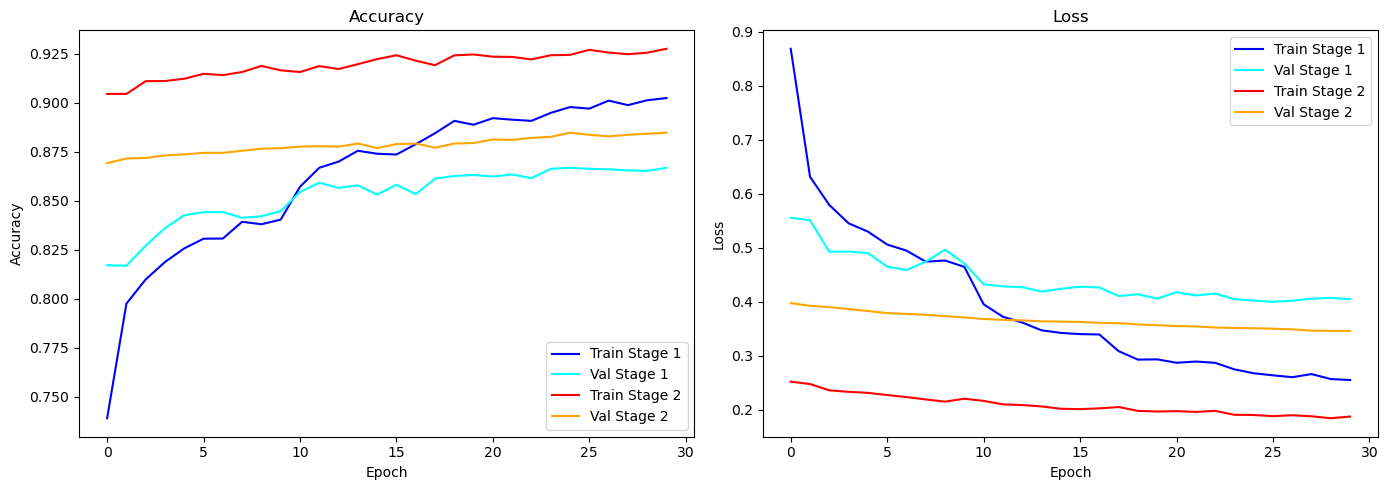

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Accuracy ---
axes[0].plot(history_stage1.history['accuracy'], label='Train Stage 1', color='blue')
axes[0].plot(history_stage1.history['val_accuracy'], label='Val Stage 1', color='cyan')
axes[0].plot(history_stage2.history['accuracy'], label='Train Stage 2', color='red')
axes[0].plot(history_stage2.history['val_accuracy'], label='Val Stage 2', color='orange')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# --- Loss ---
axes[1].plot(history_stage1.history['loss'], label='Train Stage 1', color='blue')
axes[1].plot(history_stage1.history['val_loss'], label='Val Stage 1', color='cyan')
axes[1].plot(history_stage2.history['loss'], label='Train Stage 2', color='red')
axes[1].plot(history_stage2.history['val_loss'], label='Val Stage 2', color='orange')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [7]:
# verifico accuratezza con spettri "nuovi"

img_size = (128, 128)  # usa la stessa dimensione del training
batch_size = 32

# Carica il dataset dalle cartelle
newdata = keras.utils.image_dataset_from_directory(
    "new_composite_spectra",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  
)

# Le classi (nomi delle cartelle)
class_names = newdata.class_names
print("Classi trovate:", class_names)

# Predizioni su tutto il dataset
predictions = composite_model.predict(newdata)
predicted_labels = tf.argmax(predictions, axis=1, output_type=tf.int32)
true_labels = tf.concat([y for x, y in newdata], axis=0)

# Calcola accuratezza
accuracy = tf.reduce_mean(tf.cast(predicted_labels == true_labels, tf.float32)).numpy()
print(f"Accuratezza sul dataset: {accuracy:.2%}")


Found 1900 files belonging to 19 classes.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']
60/60 [==============================] - 3s 50ms/step
Accuratezza sul dataset: 87.53%


In [8]:
import numpy as np
import tensorflow as tf

# --- assumo che tu abbia già definito:
# predictions, predicted_labels, true_labels, class_names

# Calcolo confusion matrix
num_classes = len(class_names)
conf = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=num_classes).numpy()

# Accuracy per classe = TP / numero di esempi veri per quella classe
for i, cname in enumerate(class_names):
    total = conf[i].sum()        # esempi totali in classe i
    correct = conf[i, i]         # quelli giusti (diagonale)
    acc = correct / total if total > 0 else 0.0
    print(f"Accuracy {cname:10s}: {acc*100:.2f}%  ({correct}/{total})")


Accuracy Al        : 44.00%  (44/100)
Accuracy C         : 93.00%  (93/100)
Accuracy Ca        : 47.00%  (47/100)
Accuracy Cr        : 85.00%  (85/100)
Accuracy Fe        : 97.00%  (97/100)
Accuracy H         : 96.00%  (96/100)
Accuracy He        : 91.00%  (91/100)
Accuracy Li        : 93.00%  (93/100)
Accuracy Mg        : 89.00%  (89/100)
Accuracy Mn        : 89.00%  (89/100)
Accuracy N         : 98.00%  (98/100)
Accuracy Na        : 90.00%  (90/100)
Accuracy O         : 91.00%  (91/100)
Accuracy P         : 96.00%  (96/100)
Accuracy S         : 98.00%  (98/100)
Accuracy Sc        : 86.00%  (86/100)
Accuracy Si        : 93.00%  (93/100)
Accuracy Ti        : 97.00%  (97/100)
Accuracy V         : 90.00%  (90/100)


Se togliamo Ca e Al, l'accuracy arriva ad essere attorno al 92.5%

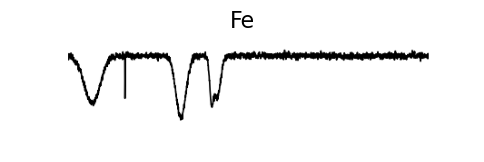

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorso dell'immagine
image_path = "training_specta_1/Fe/Fe_0004.png"

# Carica l'immagine
img = mpimg.imread(image_path)

# Crea la figura
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')  # rimuove assi
plt.title("Fe", fontsize=16)
plt.show()


ADATTO I PESI

In [8]:
# Definiamo le classi “difficili”
hard_classes = ["Ca", "Al"]

# Creiamo class_weights dinamicamente
class_weights = {i: 2.0 if name in hard_classes else 1.0 
                 for i, name in enumerate(class_names)}

print(class_weights)

{0: 2.0, 1: 1.0, 2: 2.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0}


In [11]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard


# 1) Carico il modello vecchio
old_model = keras.models.load_model("mymodel_spectra")

# 2) Congelo tutti i layer del vecchio modello
for layer in old_model.layers:
    layer.trainable = False

# 3) Prendo l’output penultimo (quello prima della classificazione vecchia)
base_output = old_model.layers[-3].output  

# 4) Aggiungo un hidden layer extra + nuovo classificatore
x = layers.Dense(128, activation="relu", name="transfer_hidden")(base_output)
x = layers.Dropout(0.4, name="transfer_dropout")(x)
new_output = layers.Dense(len(class_names), activation="softmax", name="transfer_output")(x)

# 5) Creo il nuovo modello
composite_model = models.Model(inputs=old_model.input, outputs=new_output)

# 6) Compilo - fase 1 (solo nuovi layer allenabili)
composite_model.compile(
    optimizer = keras.optimizers.SGD(
        learning_rate=1e-2,
        momentum=0.9,
        nesterov=True),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 7) Callbacks
callbacks = [
    ModelCheckpoint('best_composite_model_4.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    TensorBoard(log_dir='logs')
]

# 8) Training fase 1 (allenamento solo dei layer nuovi)
history_stage1 = composite_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# ----------------------
# FASE 2: Fine-tuning
# ----------------------

# Sblocca ultimi ~20% dei layer
for layer in old_model.layers[int(0.8 * len(old_model.layers)):]:
    layer.trainable = True

# Ricompilazione con LR più bassa (per non rovinare i pesi pre-addestrati)
composite_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),   # Adam più conservativo
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training fase 2 (fine-tuning)
history_stage2 = composite_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30
475/475 [==============================] - 33s 69ms/step - loss: 0.9353 - accuracy: 0.7274 - val_loss: 0.5562 - val_accuracy: 0.8097 - lr: 0.0100
Epoch 2/30
475/475 [==============================] - 36s 76ms/step - loss: 0.7184 - accuracy: 0.7704 - val_loss: 0.5234 - val_accuracy: 0.8229 - lr: 0.0100
Epoch 3/30
475/475 [==============================] - 39s 82ms/step - loss: 0.6568 - accuracy: 0.7924 - val_loss: 0.4996 - val_accuracy: 0.8332 - lr: 0.0100
Epoch 4/30
475/475 [==============================] - 38s 80ms/step - loss: 0.6182 - accuracy: 0.8045 - val_loss: 0.5075 - val_accuracy: 0.8355 - lr: 0.0100
Epoch 5/30
475/475 [==============================] - 38s 79ms/step - loss: 0.6062 - accuracy: 0.8071 - val_loss: 0.5278 - val_accuracy: 0.8221 - lr: 0.0100
Epoch 6/30
475/475 [==============================] - 38s 80ms/step - loss: 0.5799 - accuracy: 0.8101 - val_loss: 0.4823 - val_accuracy: 0.8411 - lr: 0.0100
Epoch 7/30
475/475 [==============================] - 38s 

In [13]:
# salvo il modello

composite_model.save("mymodel_composite_fine_tuning+weights") 

INFO:tensorflow:Assets written to: mymodel_composite_fine_tuning+weights/assets


INFO:tensorflow:Assets written to: mymodel_composite_fine_tuning+weights/assets


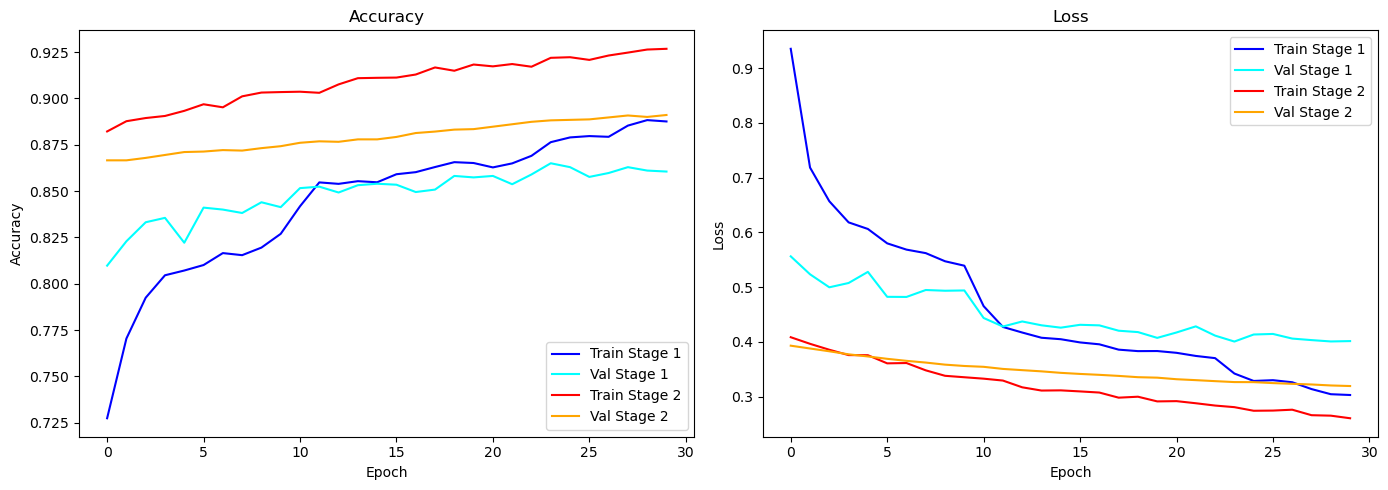

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Accuracy ---
axes[0].plot(history_stage1.history['accuracy'], label='Train Stage 1', color='blue')
axes[0].plot(history_stage1.history['val_accuracy'], label='Val Stage 1', color='cyan')
axes[0].plot(history_stage2.history['accuracy'], label='Train Stage 2', color='red')
axes[0].plot(history_stage2.history['val_accuracy'], label='Val Stage 2', color='orange')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# --- Loss ---
axes[1].plot(history_stage1.history['loss'], label='Train Stage 1', color='blue')
axes[1].plot(history_stage1.history['val_loss'], label='Val Stage 1', color='cyan')
axes[1].plot(history_stage2.history['loss'], label='Train Stage 2', color='red')
axes[1].plot(history_stage2.history['val_loss'], label='Val Stage 2', color='orange')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [15]:
# verifico accuratezza con spettri "nuovi"

img_size = (128, 128)  # usa la stessa dimensione del training
batch_size = 32

# Carica il dataset dalle cartelle
newdata = keras.utils.image_dataset_from_directory(
    "new_composite_spectra",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  
)

# Le classi (nomi delle cartelle)
class_names = newdata.class_names
print("Classi trovate:", class_names)

# Predizioni su tutto il dataset
predictions = composite_model.predict(newdata)
predicted_labels = tf.argmax(predictions, axis=1, output_type=tf.int32)
true_labels = tf.concat([y for x, y in newdata], axis=0)

# Calcola accuratezza
accuracy = tf.reduce_mean(tf.cast(predicted_labels == true_labels, tf.float32)).numpy()
print(f"Accuratezza sul dataset: {accuracy:.2%}")


Found 1900 files belonging to 19 classes.
Classi trovate: ['Al', 'C', 'Ca', 'Cr', 'Fe', 'H', 'He', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'S', 'Sc', 'Si', 'Ti', 'V']
60/60 [==============================] - 3s 49ms/step
Accuratezza sul dataset: 88.68%


In [16]:
import numpy as np
import tensorflow as tf

# --- assumo che tu abbia già definito:
# predictions, predicted_labels, true_labels, class_names

# Calcolo confusion matrix
num_classes = len(class_names)
conf = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=num_classes).numpy()

# Accuracy per classe = TP / numero di esempi veri per quella classe
for i, cname in enumerate(class_names):
    total = conf[i].sum()        # esempi totali in classe i
    correct = conf[i, i]         # quelli giusti (diagonale)
    acc = correct / total if total > 0 else 0.0
    print(f"Accuracy {cname:10s}: {acc*100:.2f}%  ({correct}/{total})")


Accuracy Al        : 46.00%  (46/100)
Accuracy C         : 93.00%  (93/100)
Accuracy Ca        : 58.00%  (58/100)
Accuracy Cr        : 86.00%  (86/100)
Accuracy Fe        : 97.00%  (97/100)
Accuracy H         : 99.00%  (99/100)
Accuracy He        : 93.00%  (93/100)
Accuracy Li        : 93.00%  (93/100)
Accuracy Mg        : 94.00%  (94/100)
Accuracy Mn        : 92.00%  (92/100)
Accuracy N         : 98.00%  (98/100)
Accuracy Na        : 89.00%  (89/100)
Accuracy O         : 93.00%  (93/100)
Accuracy P         : 94.00%  (94/100)
Accuracy S         : 98.00%  (98/100)
Accuracy Sc        : 83.00%  (83/100)
Accuracy Si        : 93.00%  (93/100)
Accuracy Ti        : 97.00%  (97/100)
Accuracy V         : 89.00%  (89/100)


OTTIMIZZO GLI IPER-PARAMETRI CON HYPEROPT

In [4]:
!pip install hyperopt


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.4 MB/s eta 0:00:00
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)


In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import numpy as np
import os

# ----------------------
# 1) Spazio di ricerca
# ----------------------
space = {
    'lr_stage1': hp.loguniform('lr_stage1', np.log(1e-4), np.log(1e-1)),
    'lr_stage2': hp.loguniform('lr_stage2', np.log(1e-6), np.log(1e-3)),
    'momentum': hp.uniform('momentum', 0.5, 0.99),
    'n_hidden': hp.quniform('n_hidden', 64, 512, 32),
    'dropout': hp.uniform('dropout', 0.2, 0.6)
}

# ----------------------
# 2) Funzione obiettivo
# ----------------------
def objective(params):
    # Carico modello base
    old_model = keras.models.load_model("mymodel_spectra")
    for layer in old_model.layers:
        layer.trainable = False

    # Nuovo classificatore
    base_output = old_model.layers[-3].output
    x = layers.Dense(int(params['n_hidden']), activation="relu", name="transfer_hidden")(base_output)
    x = layers.Dropout(params['dropout'], name="transfer_dropout")(x)
    new_output = layers.Dense(len(class_names), activation="softmax", name="transfer_output")(x)

    composite_model = models.Model(inputs=old_model.input, outputs=new_output)

    # ----------------------
    # Fase 1
    # ----------------------
    composite_model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=params['lr_stage1'],
            momentum=params['momentum'],
            nesterov=True
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Nome univoco per checkpoint e log TensorBoard
    run_id = f"run_lr1-{params['lr_stage1']:.1e}_lr2-{params['lr_stage2']:.1e}_nh-{int(params['n_hidden'])}"
    ckpt_path = f"checkpoints/best_model_{run_id}.h5"
    log_dir = os.path.join("logs", run_id)

    callbacks = [
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=0),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0),
        TensorBoard(log_dir=log_dir, histogram_freq=0)
    ]

    history_stage1 = composite_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=3,   # ridotte per tuning veloce
        callbacks=callbacks,
        verbose=0
    )

    # ----------------------
    # Fase 2
    # ----------------------
    for layer in old_model.layers[int(0.8 * len(old_model.layers)):]:
        layer.trainable = True

    composite_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['lr_stage2']),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_stage2 = composite_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=2,
        callbacks=callbacks,
        verbose=0
    )

    # Prendo la migliore accuracy di validazione
    val_acc = max(history_stage2.history['val_accuracy'])

    return {'loss': -val_acc, 'status': STATUS_OK}

# ----------------------
# 3) Lancio ricerca
# ----------------------
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

print("Migliori iperparametri trovati:", best)


100%|██████████| 20/20 [1:15:00<00:00, 225.02s/trial, best loss: -0.9065789580345154]
Migliori iperparametri trovati: {'dropout': 0.5829476799493024, 'lr_stage1': 0.00022819357993332704, 'lr_stage2': 0.0005148132775339146, 'momentum': 0.6200841500692819, 'n_hidden': 480.0}
